# Initial hyper-parameter Sensitivity Study

This section will investigate the various sensitivty models and how a set of hyper-parameters effect the accuracy of the surrogate model.
The surrogate model is based off of a sodium fast reactor, whose design space ranges includes fuel height, smear, and plutonium content.
The objectives that the surrogate model is predicting are k-eff, void coefficent, and Doppler coefficient.
There are 60 datapoints in the database that the surrogate models can use to train on.

This section examines how various hyper-parameters effect the accuracy of the surrogate model, and examines a validation curve for each of the parameters.
The models will examine each objective independently, i.e. utilize the design inputs to map to only one objective, and as a whole.
Separating the objective will help differentiate how the hyper-parameters effects predicitions for each objective.

The hyper parameters will be given in the form: [min, max, # Iterations].
Each model has the random variable set to 0, to prevent results from changing between each examination.
It is noted that linear regression does not have any hyper-parameters, and is not listed below.

In [1]:
import train_surrogate_models as tm
import db_reshape as dbr
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import model_selection

warnings.filterwarnings("ignore")

var_tot, obj_tot = dbr.reshape_database(r'sfr_db.h5', ['height', 'smear', 'pu_content'], ['keff', 'void_coeff', 'doppler_coeff'])
var_tot, obj_keff = dbr.reshape_database(r'sfr_db.h5', ['height', 'smear', 'pu_content'], ['keff'])
var_tot, obj_void = dbr.reshape_database(r'sfr_db.h5', ['height', 'smear', 'pu_content'], ['void_coeff'])
var_tot, obj_dopp = dbr.reshape_database(r'sfr_db.h5', ['height', 'smear', 'pu_content'], ['doppler_coeff'])


data_col = ['r-squared', 'mean', 'std', 'hyper-parameters', 'cv_results']
sm_db = pd.DataFrame(columns = data_col)


## Polynomial Regression

Hyper-parameter: *Poly-Degree* - [1, 7, 1]

Results:

We note a few major aspect of the graphs to examine.
Polynomials of order greater than 4 provide dreadful results, which helps indicate that the underlying physics likely does not require polynomials of this degree.
Along with this, both k-eff and the void coefficient have a high cross-validation score for degree 2 and 3, whereas the doppler coefficient sees decrease in over 50% between these values.

This plummet carries over when all of the objective are examined in tandem.
For a polynomial of degree 2, the cross-validation score is ~0.95 and decreases to < 0.8 for a 3rd order polynomial.
This is likely due to the failure of the model to capture the Doppler coefficient.

For this particular database, it is suggested that between 1st and 3th order polynomials are examined.

keff


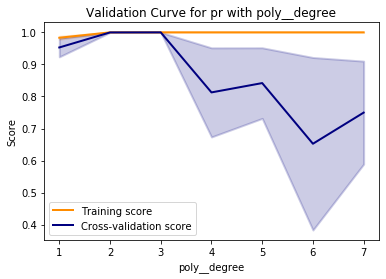

void


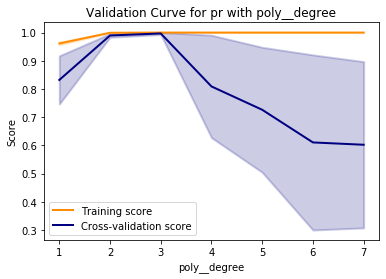

dopp


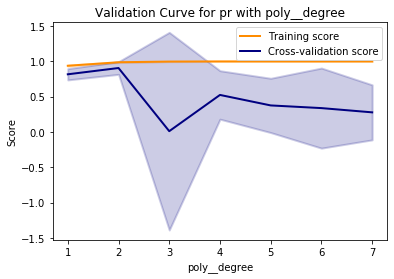

tot


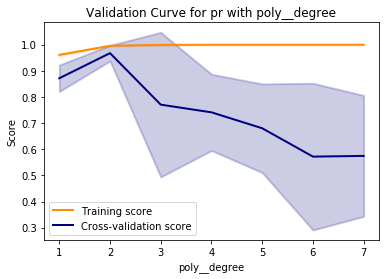

Poly Degree: {'poly__degree': 2}; Score 0.7895856837340269


In [2]:
sm = tm.Surrogate_Models()
model = 'pr'
name = ['keff', 'void', 'dopp', 'tot']
objective = [obj_keff, obj_void, obj_dopp, obj_tot]

for name, obj in zip(name, objective):
    print(name)
    sm.random = 0
    sm.update_database(var_tot, obj)
    sm.update_model(model)
    sm.plot_validation_curve(model, 'poly__degree', np.linspace(1,7,7,dtype=np.int16))
    sm.clear_surrogate_model()
    
sm.update_database(var_tot, obj_tot)
sm.update_model(model)
sm.optimize_model(model)
score = sm.models[model]['score']
hp = sm.models[model]['hyper_parameters']
cv = sm.models[model]['cv_results']
append_dict = pd.DataFrame([[score,
                             sm_db['r-squared'].mean(axis = 0),
                             sm_db['r-squared'].std(axis = 0),
                             hp,
                             cv]], columns=data_col)
sm_db = sm_db.append(append_dict)
print('Poly Degree: {}; Score {}'.format(hp, score))


## Multi-Adaptive Regression Splines

Hyper-parameter: *endspan_alpha* - [0.01, 0.1, 100] <br />
                 *minspan_alpha* - [0.01, 0.1, 100] <br />
                 *penalty*       - [1, 10, 10] <br />
                 
The resulst for using MARS shows the ability to remove multiple hyper-parameters due to a relative insensitivity.
For *endspan_alpha*, there is little variation in cross-validation score for k-eff and the void coefficient.
For both the Doppler and the combined objectives, there is an increase of ~10% when varying the *endspan_alhpa*.
Given the relative invariance for k-eff and the void coeffificient, the value for *endspan_alpha* should be set close to 0.1 to take advantage of this.
It should be noted that additional cross-validation scores should be examined to ensure that increasing *endspan_alpha* does not negatively effect any of the other parameters.

The results for *minspan_alpha* indicate that none of the objective show any sensitivity to the values, and thus the default value should be used.

For the *penalty*, all of the objective show a similar trend.
There is considerable variation in the cross-validation score between 0 and 6, where after this it is relatively constant and produces a high cross-validation score.
Given the common trends among the objectives, it is recommended that the *penalty* be set to a value greater than 6.

For this dataset, an *endspan_alpha* of ~0.1 should be used with a penalty of >6, where the *minspan_alpha* shoudl be let as the default value.

keff


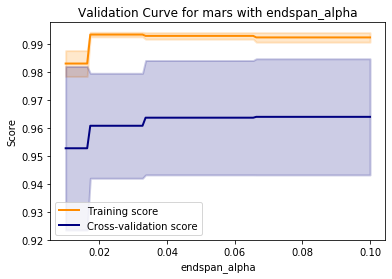

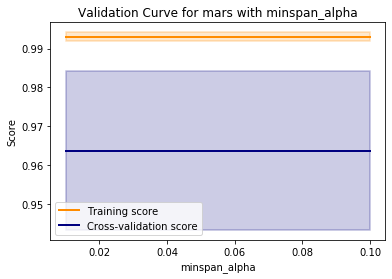

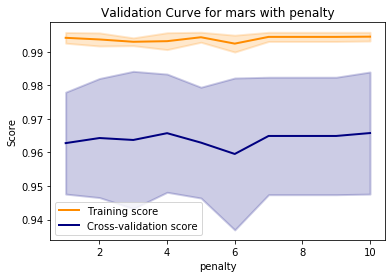


void


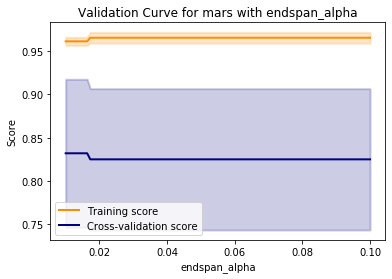

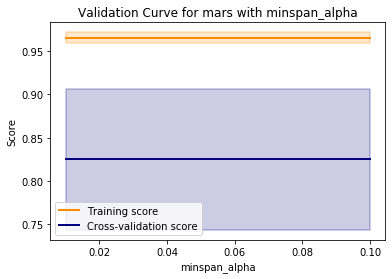

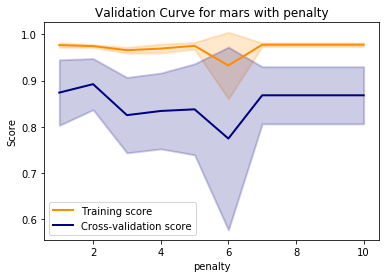


dopp


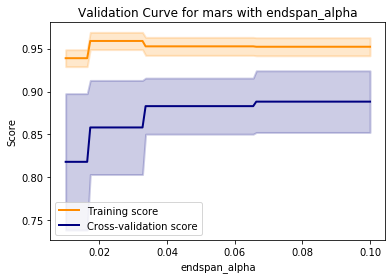

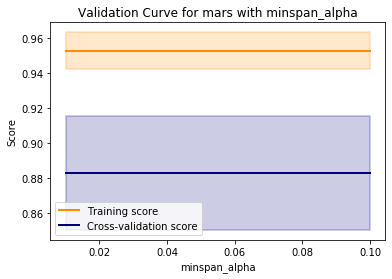

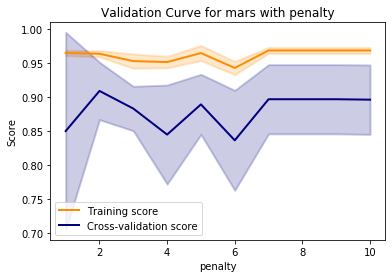


tot


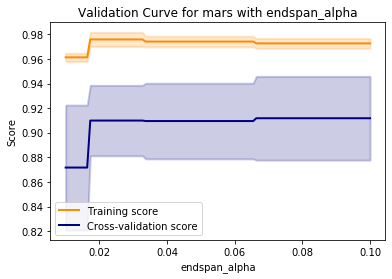

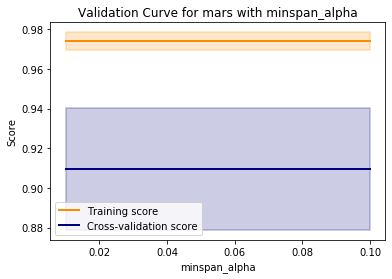

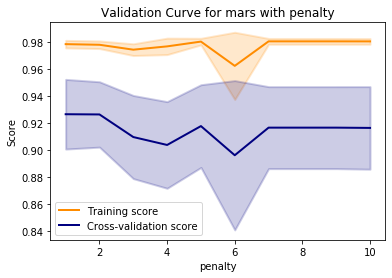


Poly Degree: {'endspan_alpha': 0.025}; Score 0.8197477296422229


In [3]:
sm = tm.Surrogate_Models()
model = 'mars'

name = ['keff', 'void', 'dopp', 'tot']
objective = [obj_keff, obj_void, obj_dopp, obj_tot]

for name, obj in zip(name, objective):
    print(name)
    sm.random = 0
    sm.update_database(var_tot, obj)
    sm.update_model(model)
    sm.plot_validation_curve(model, 'endspan_alpha', np.linspace(0.01,0.1,100))
    sm.plot_validation_curve(model, 'minspan_alpha', np.linspace(0.01,0.1,100))
    sm.plot_validation_curve(model, 'penalty', np.linspace(1,10,10))
    print('')
    sm.clear_surrogate_model()


sm.update_database(var_tot, obj_tot)
sm.update_model(model)
sm.optimize_model(model)
score = sm.models[model]['score']
hp = sm.models[model]['hyper_parameters']
cv = sm.models[model]['cv_results']
append_dict = pd.DataFrame([[score,
                             sm_db['r-squared'].mean(axis = 0),
                             sm_db['r-squared'].std(axis = 0),
                             hp,
                             cv]], columns=data_col)
sm_db = sm_db.append(append_dict)
print('MARS Degree: {}; Score {}'.format(hp, score))

## Gaussian Process Regression

Hyper-parameter: alpha - [1e-11, 1e-9, 100]

keff


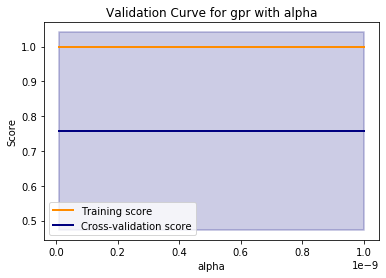


void


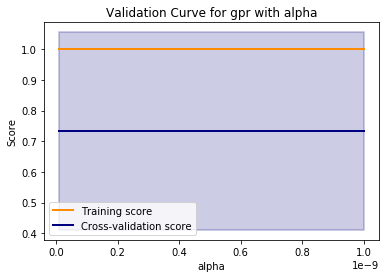


dopp


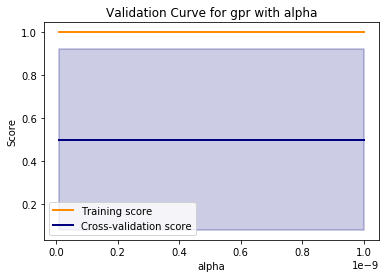


tot


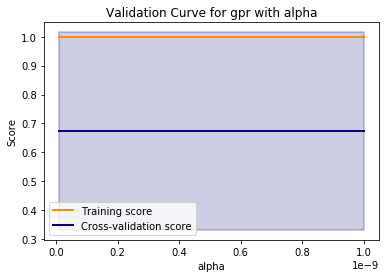


Poly Degree: {'kernel': Matern(length_scale=1, nu=1.5)}; Score 0.8986509198537418


In [4]:
from sklearn.gaussian_process.kernels import Matern, RBF, RationalQuadratic

sm = tm.Surrogate_Models()
model = 'gpr'

name = ['keff', 'void', 'dopp', 'tot']
objective = [obj_keff, obj_void, obj_dopp, obj_tot]

for name, obj in zip(name, objective):
    print(name)
    sm.random = 0
    sm.update_database(var_tot, obj)
    sm.update_model(model)
    sm.plot_validation_curve(model, 'alpha', np.linspace(1e-11,1e-9,100))
    print('')
    sm.clear_surrogate_model()


sm.update_database(var_tot, obj_tot)
sm.update_model(model)
sm.optimize_model(model)
score = sm.models[model]['score']
hp = sm.models[model]['hyper_parameters']
cv = sm.models[model]['cv_results']
append_dict = pd.DataFrame([[score,
                             sm_db['r-squared'].mean(axis = 0),
                             sm_db['r-squared'].std(axis = 0),
                             hp,
                             cv]], columns=data_col)
sm_db = sm_db.append(append_dict)
print('Poly Degree: {}; Score {}'.format(hp, score))

## Artificial Neural Network

Hyper-parameter: *hidden_layer_size* - [1,50,50]
                 *alpha*             - [0.00001,0.001,100]

keff


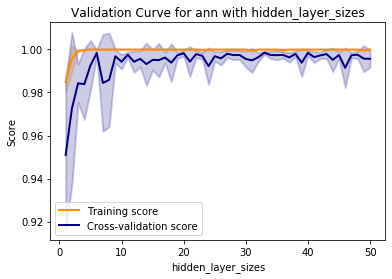

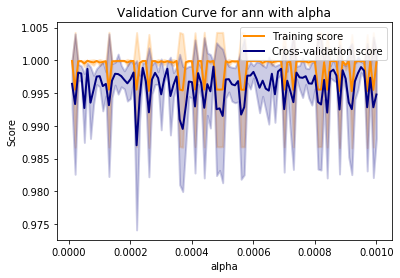


void


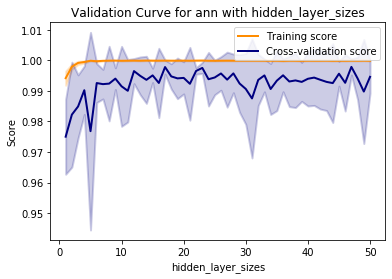

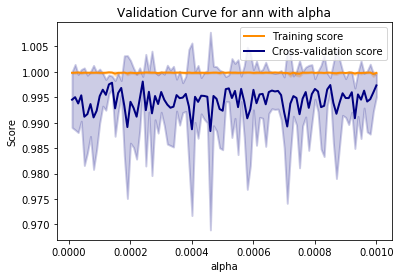


dopp


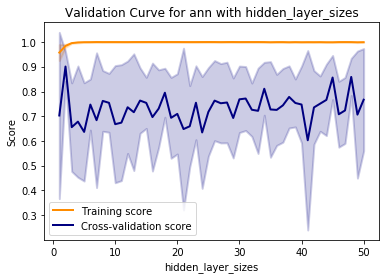

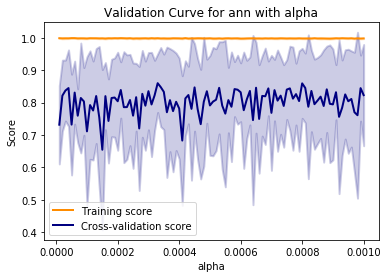


tot


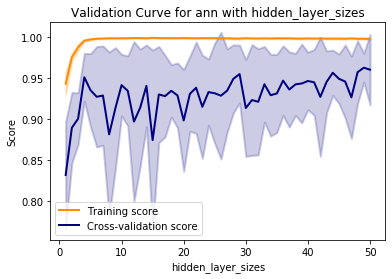

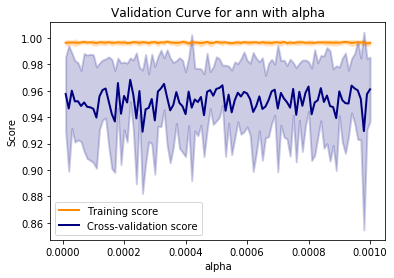


ANN: {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': 50, 'solver': 'lbfgs'}; Score 0.7057504592493801


In [5]:
sm = tm.Surrogate_Models()
model = 'ann'

name = ['keff', 'void', 'dopp', 'tot']
objective = [obj_keff, obj_void, obj_dopp, obj_tot]

for name, obj in zip(name, objective):
    print(name)
    sm.random = 0
    sm.update_database(var_tot, obj)
    sm.update_model(model)
    sm.plot_validation_curve(model, 'hidden_layer_sizes', np.linspace(1,50,50,dtype=np.int16))
    sm.plot_validation_curve(model, 'alpha', np.linspace(0.00001,0.001,100))
    print('')
    sm.clear_surrogate_model()


sm.update_database(var_tot, obj_tot)
sm.update_model(model)
sm.optimize_model(model)
score = sm.models[model]['score']
hp = sm.models[model]['hyper_parameters']
cv = sm.models[model]['cv_results']
append_dict = pd.DataFrame([[score,
                             sm_db['r-squared'].mean(axis = 0),
                             sm_db['r-squared'].std(axis = 0),
                             hp,
                             cv]], columns=data_col)
sm_db = sm_db.append(append_dict)
print('ANN: {}; Score {}'.format(hp, score))

## Random Forests

Hyper-parameters: *n-estimators* - [10,500,490]

keff


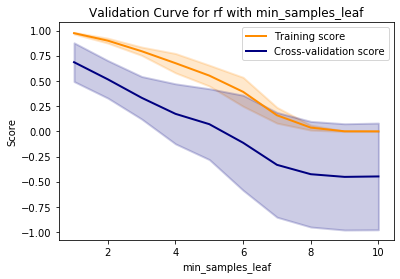

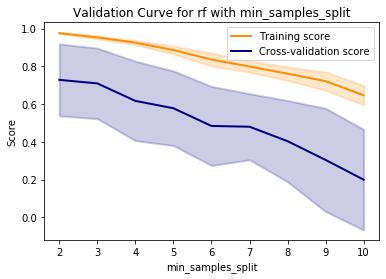


void


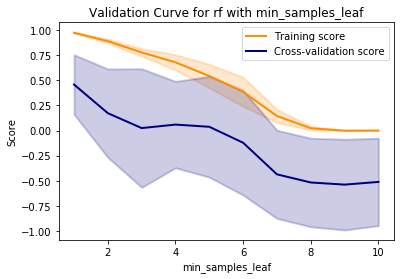

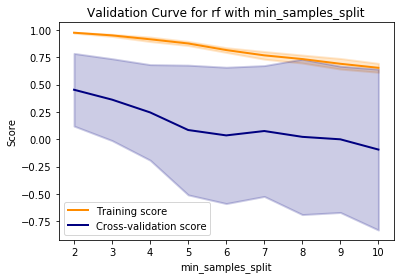


dopp


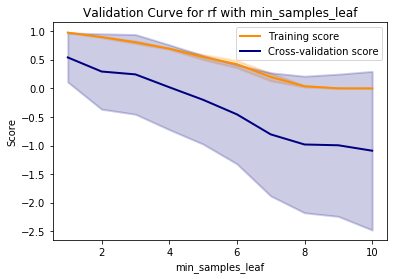

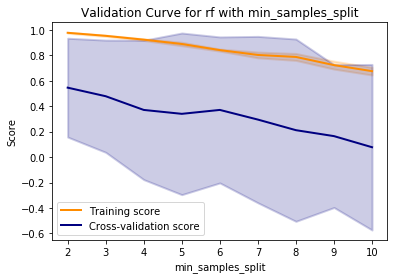


tot


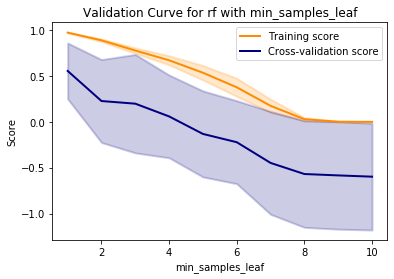

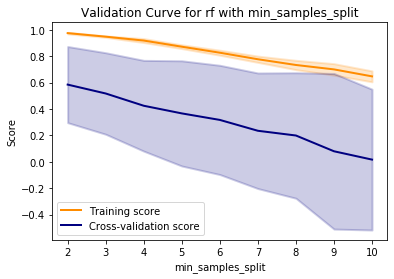


RM: {'n_estimators': 300}; Score 0.9493369138569778


In [6]:
sm = tm.Surrogate_Models()
model = 'rf'

name = ['keff', 'void', 'dopp', 'tot']
objective = [obj_keff, obj_void, obj_dopp, obj_tot]

for name, obj in zip(name, objective):
    print(name)
    sm.random = 0
    sm.update_database(var_tot, obj)
    sm.update_model(model)
#    sm.plot_validation_curve(model, 'n_estimators', np.linspace(10,500,49,dtype=np.int16))
    sm.plot_validation_curve(model, 'min_samples_leaf', np.linspace(1,10,10,dtype=np.int16))
    sm.plot_validation_curve(model, 'min_samples_split', np.linspace(1,10,10,dtype=np.int16))

    print('')
    sm.clear_surrogate_model()


sm.update_database(var_tot, obj_tot)
sm.update_model(model)
sm.optimize_model(model)
score = sm.models[model]['score']
hp = sm.models[model]['hyper_parameters']
cv = sm.models[model]['cv_results']
append_dict = pd.DataFrame([[score,
                             sm_db['r-squared'].mean(axis = 0),
                             sm_db['r-squared'].std(axis = 0),
                             hp,
                             cv]], columns=data_col)
sm_db = sm_db.append(append_dict)
print('RM: {}; Score {}'.format(hp, score))